In [1]:
#from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
from collections import deque
from os import listdir
from os.path import isfile, join
from collections import defaultdict

In [2]:
def get_ratio(country, adr, fx_dict):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]
    
#     Old exception code that we probably don't need anymore
#     try:
#         adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open'})
#     except:
#         print(f"no data for ADR data of {adr} from {country}")
#         return None
#     try:
#         stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open'})
#     except:
#         print(f"no data for underlying data of {adr} from {country}")
#         return None

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open'})
    
    fx_df = pd.read_csv(fx_path, index_col = 0)

    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close']], stock_df.loc[:,['date', 'stock_open','stock_close']])
    merged_df = pd.merge(merged_df, fx_df)

    if fx_type == 1:
        merged_df['stock_open_usd'] = merged_df['stock_open']/((merged_df['avg_bid_non_us_at'] + merged_df['avg_ask_non_us_at'])/2)
    else:
        merged_df['stock_open_usd'] = merged_df['stock_open']*((merged_df['avg_bid_non_us_at'] + merged_df['avg_ask_non_us_at'])/2)
        

    merged_df["ratio"] = merged_df['stock_open_usd']/merged_df['adr_close']
    
    ratio_geq_1 = True
    
    if np.mean(merged_df["ratio"] < 1):
        merged_df["ratio"] = 1/merged_df["ratio"]
        ratio_geq_1 = False
    
    return ratio_geq_1, np.round(np.mean(merged_df["ratio"]), 4)

In [3]:
mypath = 'eric_jh_data/'
countries = ['Australia', 'Japan', 'China']
adr_dict = {}
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

# Store ratios
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    adr_dict[country] = adr_names
    
    for adr in adr_names:
        ratio_geq_1, ratio = get_ratio(country, adr, fx_dict)
        if adr == "ACH_2600" or adr == "BGNE_6160":
            rounded_ratio = float('%.2g' % ratio)
        else:
            rounded_ratio = float('%.1g' % ratio)
        print("Country: {}, ADR_Stock: {}, Estimated Ratio (4 d.p.): {}, Implied Ratio (2 s.f.): {}".format(country, adr, ratio, rounded_ratio))
        ratio_df = pd.DataFrame({"ratio_geq_1" : [ratio_geq_1], "ratio" : [rounded_ratio]})
        ratio_df.to_csv(f'eric_jh_data/{country}/{adr}/ratio.csv')

Country: Australia, ADR_Stock: JHX_JHX, Estimated Ratio (4 d.p.): 1.003, Implied Ratio (2 s.f.): 1.0
Country: Australia, ADR_Stock: PLL_PLL, Estimated Ratio (4 d.p.): 101.803, Implied Ratio (2 s.f.): 100.0
Country: Australia, ADR_Stock: GENE_GTG, Estimated Ratio (4 d.p.): 598.1022, Implied Ratio (2 s.f.): 600.0
Country: Australia, ADR_Stock: ATHE_ATH, Estimated Ratio (4 d.p.): 60.2569, Implied Ratio (2 s.f.): 60.0
Country: Australia, ADR_Stock: IMMP_IMM, Estimated Ratio (4 d.p.): 9.9904, Implied Ratio (2 s.f.): 10.0
Country: Australia, ADR_Stock: WBK_WBC, Estimated Ratio (4 d.p.): 1.0002, Implied Ratio (2 s.f.): 1.0
Country: Australia, ADR_Stock: KZIA_KZA, Estimated Ratio (4 d.p.): 9.9188, Implied Ratio (2 s.f.): 10.0
Country: Australia, ADR_Stock: MESO_MSB, Estimated Ratio (4 d.p.): 5.0133, Implied Ratio (2 s.f.): 5.0
Country: Australia, ADR_Stock: IMRN_IMC, Estimated Ratio (4 d.p.): 38.8262, Implied Ratio (2 s.f.): 40.0
Country: Japan, ADR_Stock: HMC_7267, Estimated Ratio (4 d.p.): 0

In [4]:
def data_processing(country, adr, fx_dict):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    ratio_path = f'eric_jh_data/{country}/{adr}/ratio.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]
    
#     Old exception code that we probably don't need anymore
#     try:
#         adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open'})
#     except:
#         print(f"no data for ADR data of {adr} from {country}")
#         return None
#     try:
#         stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open'})
#     except:
#         print(f"no data for underlying data of {adr} from {country}")
#         return None

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open'})
    fx_df = pd.read_csv(fx_path, index_col = 0)
    ratio_df = pd.read_csv(ratio_path, index_col = 0)

    # Invert fx data
    if fx_type == 0:
        inverted_fx_df = 1/fx_df.iloc[:,[2,1,4,3,6,5,8,7]].copy()
        inverted_fx_df.columns = fx_df.columns[1:]
        fx_df.iloc[:,1:] = inverted_fx_df
    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close']], stock_df.loc[:,['date', 'stock_open','stock_close']])
    merged_df = pd.merge(merged_df, fx_df)
    ratio_geq_1, ratio = ratio_df["ratio_geq_1"].item(), ratio_df["ratio"].item()

#     If ratio >= 1, we shall buy 1 stock, and sell multiple adrs
#     If ratio < 1, we shall sell 1 adr, and buy multiple stocks
    if ratio_geq_1:
        merged_df["stock_num_per_unit"] = 1
        merged_df["adr_num_per_unit"] = ratio
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]*ratio
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]*ratio
    else:
        merged_df["stock_num_per_unit"] = ratio
        merged_df["adr_num_per_unit"] = 1
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]*ratio
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]*ratio
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]
        
    return merged_df

In [5]:
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    adr_dict[country] = adr_names
    
    for adr in adr_names:
        merged_df = data_processing(country, adr, fx_dict)

In [6]:
# stock_num_per_unit is how many stocks we would buy for 1 "unit" of trade
# avg_bid_non_us_before is how much foreign currency we can buy with 1 USD, 1 minute before the Asian market opens
# avg_bid_non_us_at is how much foreign currency we can buy with 1 USD, when the Asian market opens
# avg_bid_us_before is how much foreign currency we can buy with 1 USD, 1 minute before the US market opens
# avg_bid_us_at is how much foreign currency we can buy with 1 USD, when the US market opens
# All dates are in local time: so in sequential order, it will go stock_open, stock_close, adr_open, adr_close
merged_df.head()

,date,adr_open,adr_close,stock_open,stock_close,avg_bid_non_us_before,avg_ask_non_us_before,avg_bid_non_us_at,avg_ask_non_us_at,avg_bid_us_before,avg_ask_us_before,avg_bid_us_at,avg_ask_us_at,stock_num_per_unit,adr_num_per_unit,stock_open_per_unit,stock_close_per_unit,adr_open_per_unit,adr_close_per_unit
0,2015-12-01,37.33,37.57,2.79,2.89,7.75132,7.75139,7.75132,7.75139,7.75291,7.75294,7.75291,7.75296,100.0,1,279.0,289.0,37.33,37.57
1,2015-12-02,37.91,37.68,2.89,2.94,7.75205,7.75212,7.75204,7.75212,7.75020,7.75024,7.75020,7.75024,100.0,1,289.0,294.0,37.91,37.68
2,2015-12-03,38.09,37.66,2.88,2.96,7.75033,7.75041,7.75033,7.75041,7.75004,7.75008,7.75004,7.75008,100.0,1,288.0,296.0,38.09,37.66
3,2015-12-04,37.21,37.64,2.87,2.88,7.75030,7.75037,7.75030,7.75037,7.75005,7.75008,7.75005,7.75009,100.0,1,287.0,288.0,37.21,37.64
4,2015-12-07,36.87,36.47,2.85,2.84,7.75001,7.75007,7.75001,7.75007,7.75014,7.75018,7.75014,7.75018,100.0,1,285.0,284.0,36.87,36.47


In [7]:
"""
Naive strategy for testing on the SONY adr and stock pair
To open a position, we check the CLOSE price of adr, compared it to CLOSE px of 
stock. We buy the stock on the next trading next OPEN for Asian market

To close a position,  we check the CLOSE price of adr, compared it to CLOSE px of 
stock. We sell the stock on the next trading next OPEN for Asian market
"""
def pairs_trade(merged_df, lookback = 100, cash = 100000):

    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    diff_record_bid = deque(maxlen = lookback)
    diff_record_ask = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    hits = []

    for index, row in merged_df.iterrows():
        portfolio_values.append(cash + adr_pos*row['adr_close'] + stock_pos*(row['stock_close']/row['avg_ask_us_at']))
        # check if there is a px diff between close and stock_close effective
        # If len(diff_record) < lookback, we do not place any trade
        if index+1 < len(merged_df):
            diff_record_bid.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])
            diff_record_ask.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_ask_non_us_before'])

            if len(diff_record_bid) < lookback:
                continue

            # If we have passed the initial lookback window
            # enter the position if diff is significant
            if diff_record_bid[-1] > np.array(diff_record_ask).mean() + np.array(diff_record_bid).std():
                if stock_pos == 0 and adr_pos == 0:

                    units = min(int((0.5*cash)/row['adr_close_per_unit']),int((0.5*cash)/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_bid_non_us_before'])))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    adr_pos -= adr_quantity
                    cash += adr_quantity*merged_df.loc[index+1,'adr_open']

                    stock_pos += stock_quantity
                    stock_px = merged_df.loc[index+1,'stock_open']/merged_df.loc[index+1,'avg_bid_non_us_at']
                    # The actual px we get to trade is on the next day for asian market
                    cash -= stock_px*stock_quantity

                    trade_records.append("Opening positions:\n")
                    trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {merged_df.loc[index+1,'adr_open']} on {merged_df.loc[index+1,'date']}\n")
                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px} USD ({merged_df.loc[index+1,'stock_open']} foreign dollars) on {merged_df.loc[index+1,'date']}\n")
                    portfolio_value_before_entering = portfolio_values[-1]

            # When do we exit the position?
            elif diff_record_ask[-1] < np.array(diff_record_ask).mean():
                if stock_pos > 0 and adr_pos < 0 : # If we have positions in the stocks, we liquidate the position
                    cash -= abs(adr_pos)*merged_df.loc[index+1,'adr_open']
                    stock_px = merged_df.loc[index+1,'stock_open']/merged_df.loc[index+1,'avg_ask_non_us_before']
                    cash += stock_pos*stock_px

                    trade_records.append("Closing positions:\n")
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {merged_df.loc[index+1,'adr_open']} on {merged_df.loc[index+1,'date']}\n")
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px} USD ({merged_df.loc[index+1,'stock_open']} foreign dollars) on {merged_df.loc[index+1,'date']}\n")
                    stock_pos, adr_pos = 0, 0
                    portfolio_value_after_exiting = cash
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash
    
    return ret, trade_records, portfolio_values, hits

In [8]:
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    adr_dict[country] = adr_names
    
    for adr in adr_names:
        merged_df = data_processing(country, adr, fx_dict)
        ret, trade_records, portfolio_values, hits = pairs_trade(merged_df)
        ret = np.round(ret*100, 2)
        hit_ratio = None
        logs = [f'The return of ADR_underlying pairs trading for {adr} from {country} is {0.00}%, no trades were placed.\n']
        if hits:
            hit_ratio = np.round(np.mean(hits)*100,2)
            logs = [f'The return of ADR_underlying pairs trading for {adr} from {country} is {ret}%\nThe hit ratio is {hit_ratio}%\n']
            print("Country: {}, ADR_Stock: {}, Return: {}%, Hit Ratio: {}%".format(country, adr, ret, hit_ratio))
        else:
            print("Country: {}, ADR_Stock: {}, Return: {}%, Hit Ratio: None".format(country, adr, ret))
        logs = logs + trade_records 
        fname = f'eric_jh_data/{country}/{adr}/logs1.txt'
        f = open(fname, 'w')
        f.writelines(logs)
        f.close()

Country: Australia, ADR_Stock: JHX_JHX, Return: -11.34%, Hit Ratio: 43.4%
Country: Australia, ADR_Stock: PLL_PLL, Return: 14.13%, Hit Ratio: 80.0%
Country: Australia, ADR_Stock: GENE_GTG, Return: 135.27%, Hit Ratio: 78.57%
Country: Australia, ADR_Stock: ATHE_ATH, Return: 148.42%, Hit Ratio: 92.59%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 24.84%, Hit Ratio: 85.71%
Country: Australia, ADR_Stock: WBK_WBC, Return: -0.26%, Hit Ratio: 54.05%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 124.14%, Hit Ratio: 87.1%
Country: Australia, ADR_Stock: MESO_MSB, Return: 146.05%, Hit Ratio: 82.93%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 49.42%, Hit Ratio: 92.31%
Country: Japan, ADR_Stock: HMC_7267, Return: -1.3%, Hit Ratio: 42.86%
Country: Japan, ADR_Stock: CAJ_7751, Return: 6.1%, Hit Ratio: 59.09%
Country: Japan, ADR_Stock: SMFG_8316, Return: -4.72%, Hit Ratio: 55.1%
Country: Japan, ADR_Stock: IX_8591, Return: 0.14%, Hit Ratio: 50.0%
Country: Japan, ADR_Stock: MFG_8411, Return: 0.7

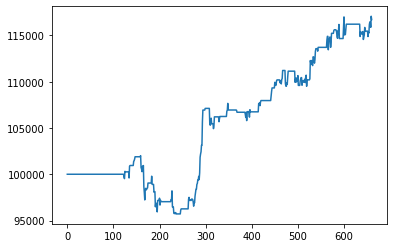

In [9]:
plt.plot(portfolio_values)